# Helpers

In [0]:
def get_activations(img, base_model, activation = 1, print_ = False):
    """
    Returns ReLUs of layer specified by parameter activation

    :param img: np.array
    :param base_model: Keras Model
    :param activation_: int
    :return:
    """
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)
    if print_: print("Shape of input:", img.shape)
    
    model = Model(inputs=base_model.input,
                  outputs=base_model.get_layer('activation_' + str(activation)).output)

    activation = model.predict(img)
    if print_: print("Shape of output:", activation.shape)
    
    return activation
  
def remove_specific_label(X, y, label = 1):
    not_label = y != label
    return X[not_label], y[not_label]
  
def intialize_train(X_train, y_train, X_val, y_val, params):
    
    dim = params['dim']
    neurons = params.pop('neurons', 512)
    batch_size = params.pop('batch_size', 20)
    epochs = params.pop('epochs', 20)
    learning_rate = params.pop('lr', 2e-5)
    
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim= dim[1] * dim[2] * dim[3], kernel_initializer='random_uniform'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        #callbacks=params['callbacks']
                       )
    
    return history, model
  
def get_indices_of_wrong_classified_images(X, y, test_indices, model):
    test_idx_wrong_classified = model.predict_classes(X).flatten() != y
    img_wrong_classified = test_indices[test_idx_wrong_classified]
    return img_wrong_classified

  
  
import pickle

def save_obj(obj, fullpath):
    with open(fullpath + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fullpath):
    with open(fullpath + '.pkl', 'rb') as f:
        return pickle.load(f)
      
      
def save_keras_model(model, path, fold, res):

    fullpath = os.path.join(path, 'model' + '_res' + str(res) + '_fold' + str(fold))
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(fullpath + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(fullpath + ".h5")
    print("Saved model to disk")


# RestNetActivations and Fully Connected layers

IDEAS:
* data augmentation
* load images on batches (generator)
* variable architecture for different resolutions (layers, epochs, etc)
* show example images for every category and every label
* show images on which the algorithm fails
* what happens with the ResNet architecture for very small images?
* cross validation accuracy and std
* have more images, let's have on the order of 2000 images
* use the label 1 images as test set
* calculate activations and then train networks

In [0]:
pip install python-dotenv

In [0]:
# pip install git+https://github.com/qubvel/classification_models.git
# potentially with smaller pretrained ResNet architectures
# from classification_models.resnet import ResNet18, ResNet34, preprocess_input

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

import gc
import numpy as np
import pandas as pd
import sys
import os
import datetime
import math

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [0]:
try: # if running on COLAB
    
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = '/content/drive/My Drive/Colab/MasterThesis/'
    #PATH_IMG = "/content/drive/My Drive/MFP - Satellogic/images/"
    PATH_IMG = "/content/drive/My Drive/MDS/MFP - Satellogic/images/"
    
    # confirm GPU is available
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')

except:
    from dotenv import load_dotenv
    sys.path.append("../Library/")
    import image_manipulation as ima
    PATH = os.path.join(os.getenv('GDRIVE_FOLDER'), 'Colab/MasterThesis')
    PATH_IMG = os.path.join(os.getenv('GDRIVE_FOLDER'), 'MFP - Satellogic/images/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
BASE_RES = 1
BASE_RES_NAME = "0.3-1"

PATH_DATA = os.path.join(PATH, 'Data/')
PATH_DATA_RES = os.path.join(PATH_DATA, str(BASE_RES_NAME) + 'm/')
PATH_LIB = os.path.join(PATH, 'Library/')
PATH_MOD = os.path.join(PATH, 'Models/')
PATH_NOTE = os.path.join(PATH, 'Notebooks/')
PATH_RESULTS = os.path.join(PATH, "Results_" + str(BASE_RES_NAME) + "m_excl_label1")
sys.path.append(PATH_LIB)

print("Folders content:")
print("PATH:\t\t", os.listdir(PATH))
print("PATH DATA:\t", os.listdir(PATH_DATA))
print("PATH DATA_RES:\t", os.listdir(PATH_DATA_RES))
print("PATH LIBRARY:\t", os.listdir(PATH_LIB))
print("PATH MODELS:\t", os.listdir(PATH_MOD))
print("PATH NOTEBOOKS:\t", os.listdir(PATH_NOTE))
print("PATH IMAGES:\t", os.listdir(PATH_IMG))
print("PATH RESULTS:\t", os.listdir(PATH_RESULTS))

Folders content:
PATH:		 ['.env', 'Notebooks', 'Library', 'Data', 'Models', 'Results_0.3m_excl_label1', 'Results_1m_excl_label1', 'Results_0.3-1m_excl_label1']
PATH DATA:	 ['X_activations_res0.3.npy', 'X_images_res0.3.npy', 'y_images_res0.3.npy', 'result_res0.9.csv', 'result_res1.2.csv', 'result_res1.5.csv', 'result_res1.8.csv', 'result_res2.1.csv', 'result_res2.4.csv', 'result_res2.7.csv', 'result_res3.0.csv', 'result_res3.3.csv', 'result_res3.6.csv', 'result_res3.9.csv', 'result_res4.2.csv', 'result_res4.5.csv', 'result_res4.8.csv', 'result_res0.6.csv', 'X_act_res2.4.npy', 'X_act_res2.7.npy', 'X_act_res0.6.npy', 'X_act_res0.9.npy', 'X_act_res1.2.npy', 'X_act_res1.5.npy', 'X_act_res1.8.npy', 'X_act_res2.1.npy', 'X_act_res3.0.npy', 'X_act_res3.3.npy', 'X_act_res3.6.npy', 'X_act_res3.9.npy', 'X_act_res4.2.npy', 'X_act_res4.5.npy', 'X_act_res4.8.npy', '1m', '0.3-1m']
PATH DATA_RES:	 ['categories_images_res0.3-1.npy', 'X_images_res0.3-1.npy', 'y_images_res0.3-1.npy', 'filenames_images_res

In [0]:
%load_ext autoreload
%autoreload 2
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml

In [0]:
def print_time(string=''):
    print('', str(datetime.datetime.today())[:22], string)
    return

## Train complete network from source images

### Load Data

In [0]:
X_name = 'X_images_res' + str(BASE_RES_NAME) + '.npy'
y_name = 'y_images_res' + str(BASE_RES_NAME) + '.npy'
filenames_name = 'filenames_images_res' + str(BASE_RES_NAME) + '.npy'
categories_name = 'categories_images_res' + str(BASE_RES_NAME) + '.npy'

X_base, y = np.load(os.path.join(PATH_DATA_RES, X_name)), np.load(os.path.join(PATH_DATA_RES, y_name), allow_pickle = True)
filenames, categories = np.load(os.path.join(PATH_DATA_RES, filenames_name), allow_pickle = True), np.load(os.path.join(PATH_DATA_RES, categories_name), allow_pickle = True)

filename: 11u_lp_465715x3290_y3355__size512_baseres1m.png
category: forest-woodland
label: 0


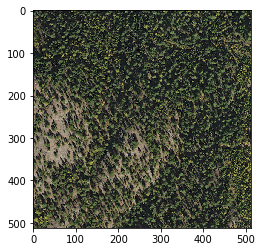

In [0]:
img = 0
print("filename:", filenames[img])
print("category:", categories[img])
print("label:", y[img])
plt.imshow(X_base[img])

### Resolutions

In [0]:
base_res = BASE_RES
base_size = 512
N_RES = 17

sizes = {base_res: (base_size, base_size)}
for factor in range(2, N_RES):
    res = round(base_res * factor,1)
    size = round(base_size/factor)
    sizes[res] = (size, size)
print("Sizes dictionary:\n", sizes)

Sizes dictionary:
 {1: (512, 512), 2: (256, 256), 3: (171, 171), 4: (128, 128), 5: (102, 102), 6: (85, 85), 7: (73, 73), 8: (64, 64), 9: (57, 57), 10: (51, 51), 11: (47, 47), 12: (43, 43), 13: (39, 39), 14: (37, 37), 15: (34, 34), 16: (32, 32)}


### List of all resolutions (including base):

In [0]:
resolutions = [res for res in sizes]
resolutions.sort()
print(resolutions)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


### List of all categories

In [0]:
CATEGORIES = ["forest-woodland", "agriculture", "shrubland-grassland", "semi-desert"]

### Load base NN model

Load ResNet and set all layers to `trainable = False` and list *activation* layers:

In [0]:
base_model = ResNet50(weights='imagenet',
                      include_top=False)

activation_layers = []
for l in base_model.layers:
    l.trainable = False
    if "activation" in l.name or "relu" in l.name:
        activation_layers.append(l.name)
print(activation_layers)

W0618 18:20:58.856553 139803764070272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 18:20:58.861288 139803764070272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 18:20:58.872874 139803764070272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0618 18:20:58.910163 139803764070272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 18:20:58.911076

94658560/94653016 [==============================] - 6s 0us/step
['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49']


In [0]:
#base_model.summary()

# Run DL pipeline for all resolutions

In [0]:
import keras
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=3,
        verbose=0,
        mode='auto'
    )
]


In [0]:
SAVE_RESULT = True
SAVE_MODEL = False
RESOLUTIONS = resolutions[1:]


N_images = X_base.shape[0]
from sklearn.model_selection import StratifiedKFold

kFold = StratifiedKFold(n_splits=8, random_state = 40)
batch_size = 50
results = []

N_ACTIVATIONS = len(activation_layers)
act_layer = activation_layers[N_ACTIVATIONS-1]

for res in RESOLUTIONS:

    ## Activations and Preprocessing
    print("\n--- Getting Activations for resolution", res, "---\n")
    
    ## Load Activations from disk, if exist
    path_act = os.path.join(PATH_DATA_RES, 'X_act_res' + str(res) + '.npy')
    if os.path.exists(path_act):
        print("loading activation from disk...")
        X_act = np.load(path_act)
    else:
        ## Degrading
        print("computing activations...")
        X = np.array([ima.degrade_image(X_base[i], sizes[res]) for i in range(N_images)])
        X_act = get_activations(X[0], base_model, int(activation_layers[-1].split("_")[-1]))
        for i in range(1, X.shape[0], batch_size):
            X_act = np.r_[X_act, get_activations(X[i:i+batch_size], base_model, int(activation_layers[-1].split("_")[-1]))]
        np.save(path_act, X_act)
        del X
        gc.collect()
    X_act = preprocess_input(X_act)

    ## Initialize parameters for CV
    params = {}
    fold = 0
    result_per_res = []
    
    ## Training with CV
    for train, val in kFold.split(X_act, y):
        
        print("\n ---- Processing fold", fold, "at resolution", res, "--- \n")
        
        #print(train)
        #print(val)
        #img = train[0]
        #print("filename:", filenames[img])
        #print("category:", categories[img])
        #print("label:", y[img])
        #plt.imshow(X_base[img])
        
        dim = X_act.shape
        X_train = np.reshape(X_act[train], (X_act[train].shape[0], dim[1] * dim[2] * dim[3]))
        X_val = np.reshape(X_act[val], (X_act[val].shape[0], dim[1] * dim[2] * dim[3]))
        y_train, y_val = y[train], y[val]

        params['dim'] = dim
        params['batch_size'] = batch_size
        params['epochs'] = 30
        params['neurons'] = 100 #256
        params['callbacks'] = callbacks
        
        print_time("training...")
        history, model = intialize_train(X_train, y_train, X_val, y_val, params)
        del X_train, y_train
        gc.collect()

        print_time("evaluating...")
        loss, acc = model.evaluate(X_val, y_val)
        print('Accuracy:', acc)
        
        # Get indices of wrongly classified images
        img_wrong_classified = get_indices_of_wrong_classified_images(X_val, y_val, val, model)
                
        if SAVE_MODEL: save_keras_model(model, PATH_RESULTS, fold, res)
        
        result = {
            "wrong_class": img_wrong_classified.tolist(),
            "resolution": res,
            "accuracy": acc,
            "loss": loss,
            #"history": history,
            "fold": fold
        }
        
        for cat in CATEGORIES:
            val_cat_idx = categories[val] == cat
            X_val_cat = X_val[val_cat_idx]
            y_val_cat = y_val[val_cat_idx]
            loss, acc_cat = model.evaluate(X_val_cat, y_val_cat)
            result["accuracy_"+cat] = acc_cat
            print('Category:', cat, "Accuracy:", acc_cat) 
        
        del X_val, y_val, X_val_cat, y_val_cat, model, history
        gc.collect()
        
        result_per_res.append(result) 
        fold += 1
     
    if SAVE_RESULT: pd.DataFrame(result_per_res).to_csv(os.path.join(PATH_RESULTS, "result_res" + str(res) + ".csv"), index=False)


gc.collect()

del X_act

print_time("DONE! \n")   


--- Getting Activations for resolution 2 ---

computing activations...

 ---- Processing fold 0 at resolution 2 --- 



W0618 18:22:49.527821 139803764070272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0618 18:22:49.542346 139803764070272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 2019-06-18 18:22:49.48 training...
Train on 1207 samples, validate on 173 samples
Epoch 1/30
1207/1207 [==============================] - 2s 2ms/step - loss: 4.0778 - acc: 0.6263 - val_loss: 1.7560 - val_acc: 0.7803
Epoch 2/30
1207/1207 [==============================] - 1s 608us/step - loss: 1.2430 - acc: 0.7970 - val_loss: 1.5006 - val_acc: 0.7630
Epoch 3/30
1207/1207 [==============================] - 1s 601us/step - loss: 0.8116 - acc: 0.8525 - val_loss: 1.6493 - val_acc: 0.7919
Epoch 4/30
1207/1207 [==============================] - 1s 600us/step - loss: 0.5710 - acc: 0.8865 - val_loss: 2.2010 - val_acc: 0.7746
Epoch 5/30
1207/1207 [==============================] - 1s 600us/step - loss: 0.4524 - acc: 0.9163 - val_loss: 1.2588 - val_acc: 0.8092
Epoch 6/30
1207/1207 [==============================] - 1s 629us/step - loss: 0.3124 - acc: 0.9345 - val_loss: 1.2187 - val_acc: 0.8208
Epoch 7/30
1207/1207 [==============================] - 1s 632us/step - loss: 0.2474 - acc: 0.9569 - va

In [0]:
stop here

SyntaxError: ignored

### Results

In [0]:
res = 2
df_results = pd.read_csv(os.path.join(PATH_RESULTS, "result_res" + str(res) + ".csv"))
for res in resolutions[1:]:
    df_results = df_results.append(pd.read_csv(os.path.join(PATH_RESULTS, "result_res" + str(res) + ".csv")))

In [0]:
mask = df_results["accuracy"] > 0.7
df_results = df_results[mask]

In [0]:
grouped_results = df_results.groupby(['resolution'], as_index=False).agg({
	'accuracy':['mean','std'], 
	'accuracy_agriculture':['mean','std'],
	'accuracy_forest-woodland':['mean','std'],
	'accuracy_semi-desert':['mean','std'],
	'accuracy_shrubland-grassland':['mean','std'],
})

#grouped_results.fillna(0, inplace=True)
grouped_results

resolution  accuracy  ... accuracy_shrubland-grassland          
                   mean  ...                         mean       std
0           2  0.846573  ...                     0.836793  0.048327
1           3  0.842731  ...                     0.832570  0.045899
2           4  0.842046  ...                     0.820963  0.070444
3           5  0.829361  ...                     0.841850  0.041338
4           6  0.803666  ...                     0.787853  0.056442
5           7  0.803684  ...                     0.795799  0.027400
6           8  0.801266  ...                     0.792519  0.057580
7           9  0.811564  ...                     0.779030  0.060706
8          10  0.795626  ...                     0.767091  0.042525
9          11  0.774664  ...                     0.735869  0.043401
10         12  0.777952  ...                     0.732052  0.053229
11         13  0.758240  ...                     0.700081  0.082700
12         14  0.760187  ...                     0.688053  0.081095
13         15  0.762364  ...                     0.692319  0.073591
14         16  0.788476  ...                     0.762734  0.022817

[15 rows x 11 columns]

Accuracy for each resolution:

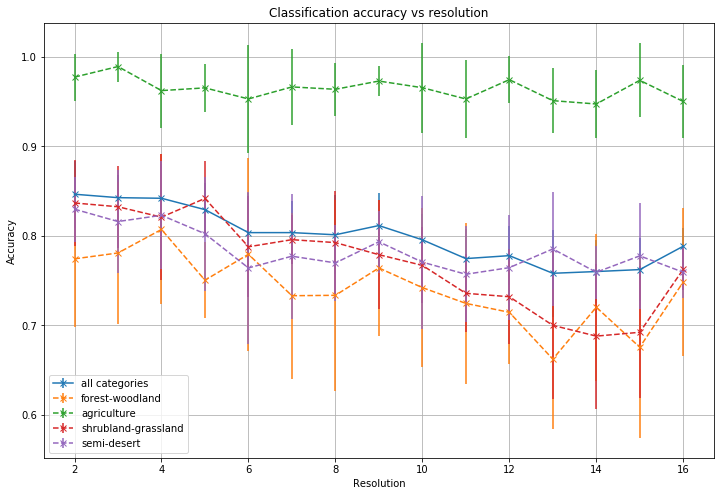

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.errorbar(
    grouped_results["resolution"], 
    grouped_results["accuracy"]["mean"], 
    grouped_results["accuracy"]["std"],
    #linestyle='dashed', 
    marker='x', 
    label="all categories"
) 

for cat in CATEGORIES:
    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], 
        grouped_results[acc]["mean"], 
        grouped_results[acc]["std"],
        linestyle='dashed', marker='x', label=cat
    ) 

ax.set(
    xlabel="Resolution",
    ylabel="Accuracy",
    title = "Classification accuracy vs resolution"
)
ax.grid()
ax.legend()

plt.show()
#fig.savefig(PATH_NOTE + 'img/acc_vs_res_' + str(datetime.datetime.today())[:16].replace(":",".") + '_.png', bbox_inches='tight')

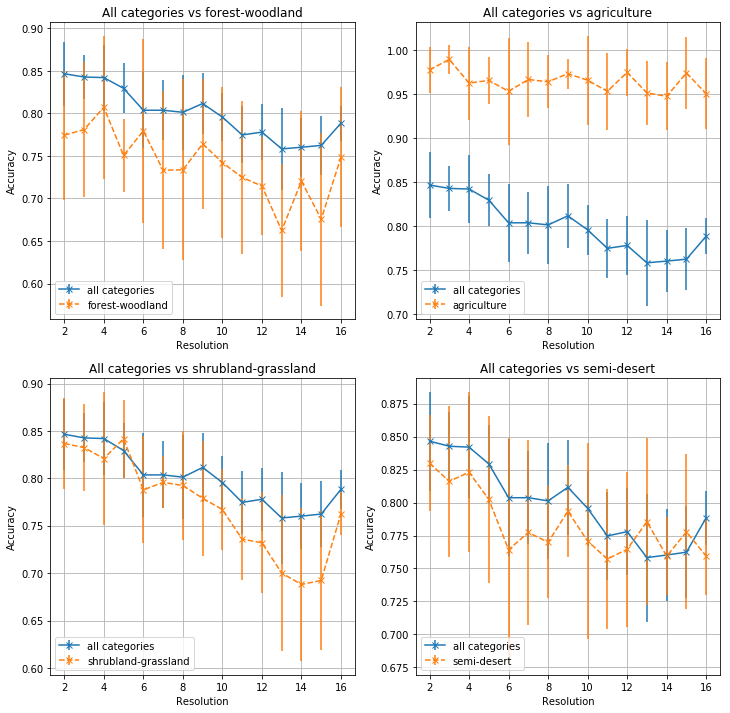

In [0]:
inch_per_plot = 6
fig = plt.figure()
array_width = 2
array_height = math.ceil(len(CATEGORIES)/array_width)
fig.set_size_inches(array_width*inch_per_plot,array_height*inch_per_plot)

for index, cat in enumerate(CATEGORIES):
    ax = fig.add_subplot(array_height,array_width,index+1) 

    ax.errorbar(
        grouped_results["resolution"], 
        grouped_results["accuracy"]["mean"], 
        grouped_results["accuracy"]["std"],
        #linestyle='dashed', 
        marker='x', 
        label="all categories"
    ) 

    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], 
        grouped_results[acc]["mean"], 
        grouped_results[acc]["std"],
        linestyle='dashed', marker='x', label=cat
    ) 

    ax.set(
        xlabel="Resolution",
        ylabel="Accuracy",
        title = "All categories vs " + cat
    )
    ax.grid()
    ax.legend(loc='lower left')

plt.show()